In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


df=pd.read_csv(r"C:\Users\Lenovo\OneDrive - IMAM ABDULRAHMAN BIN FAISAL UNIVERSITY\Desktop\Fraud detection project\AIML Dataset.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
 10  isFlaggedFraud  1048575 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 88.0+ MB


In [52]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [53]:
df["isFraud"].value_counts()

isFraud
0    1047433
1       1142
Name: count, dtype: int64

In [54]:
df["isFlaggedFraud"].value_counts()

isFlaggedFraud
0    1048575
Name: count, dtype: int64

In [55]:
df.isnull().sum().sum()

np.int64(0)

In [56]:
df.shape

(1048575, 11)

In [57]:
round((df["isFraud"].value_counts()[1]/df.shape[0])*100,2)

np.float64(0.11)

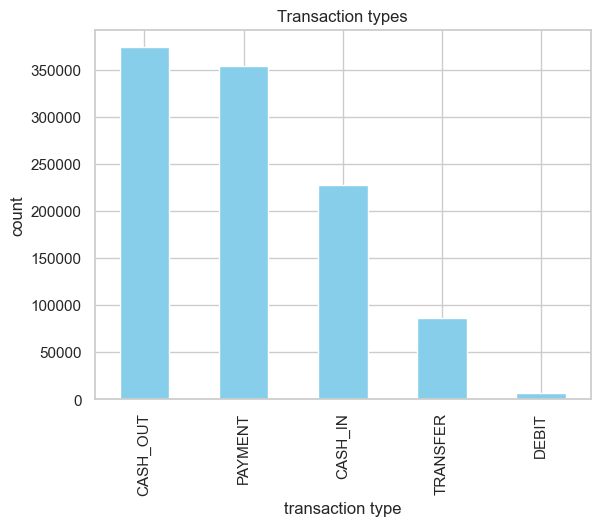

In [58]:
df["type"].value_counts().plot(kind="bar",title="Transaction types",color="skyblue")
plt.xlabel("transaction type")
plt.ylabel("count")
plt.show()

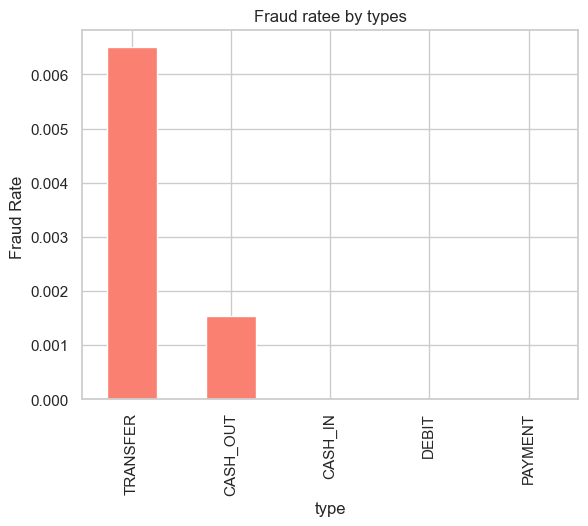

In [59]:
fraud_by_type=df.groupby("type")["isFraud"].mean().sort_values(ascending=False)
fraud_by_type.plot(kind="bar",title="Fraud ratee by types",color="salmon")
plt.ylabel("Fraud Rate ")
plt.show()

In [60]:
df["amount"].describe().astype(int)

count     1048575
mean       158666
std        264940
min             0
25%         12149
50%         76343
75%        213761
max      10000000
Name: amount, dtype: int64

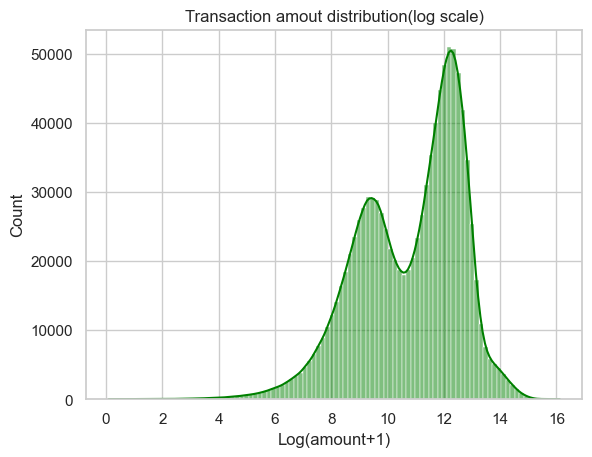

In [61]:
sns.histplot(np.log1p(df["amount"]),bins=100,kde=True,color="green")
plt.title("Transaction amout distribution(log scale)")
plt.xlabel("Log(amount+1)")
plt.show()

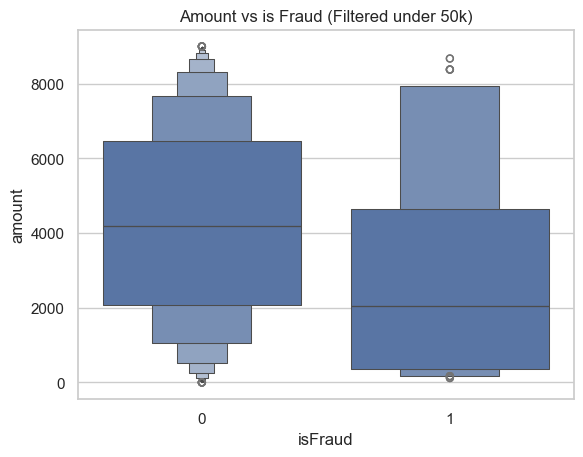

In [62]:
sns.boxenplot(data=df[df["amount"]<9000],x="isFraud",y="amount")
plt.title("Amount vs is Fraud (Filtered under 50k)")
plt.show() #questionable 

In [63]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [64]:
df["balanceDiffOrig"]=df["oldbalanceOrg"]-df["newbalanceOrig"]
df["balancediffdest"]=df["newbalanceDest"]-df["oldbalanceDest"]

In [65]:
#checks for unexpected negative values
(df["balanceDiffOrig"]<0).sum()

np.int64(227102)

In [66]:
(df["balancediffdest"]<0).sum()

np.int64(204144)

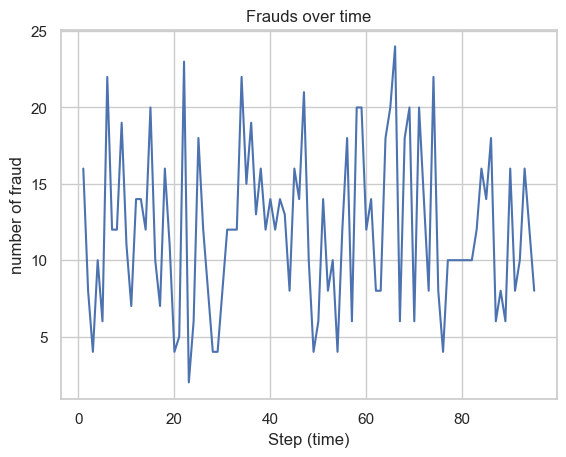

In [69]:
fraud_per_step=df[df["isFraud"]==1]["step"].value_counts().sort_index()
plt.plot(fraud_per_step.index,fraud_per_step.values,label="fraud per step")
plt.xlabel("Step (time)")
plt.ylabel("number of fraud")
plt.title("Frauds over time")
plt.grid(True)
plt.show()


In [ ]:
#irregular fluctuations that can not be use as indicator
df.drop(columns="step",inplace=True)

In [ ]:
top_sender=df["nameOrig"].value_counts()

In [ ]:
#missed view steps countinue later, til heatmap

In [ ]:
# moving entire account in one transaction (transfering or cash out )  can be fraudlant 
zero_after_transfer=df[
    (df["oldbalanceOrg"]>0)& 
    (df["newbalanceOrig"]==0)&
    (df["type"].isin(["TRANSFER","CASH _OUT"]))]

In [80]:
len(zero_after_transfer)

37621

In [82]:
df["isFraud"].value_counts()

isFraud
0    1047433
1       1142
Name: count, dtype: int64

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


In [103]:
df.columns

Index(['type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'balanceDiffOrig', 'balancediffdest'],
      dtype='object')

In [104]:
df_model=df.drop(["nameOrig","nameDest","isFlaggedFraud"],axis=1)


In [105]:
categorical=["type"]
numeric=["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest",'newbalanceDest']

In [182]:

#y = df["isFraud"].values.ravel()
#y = df[["isFraud"]].to_numpy().ravel()
y = df[["isFraud"]].values.reshape(-1)


x=df_model.drop("isFraud",axis=1)

In [183]:
x

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,balanceDiffOrig,balancediffdest
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,9839.64,0.00
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,1864.28,0.00
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,181.00,0.00
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,181.00,-21182.00
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,11668.14,0.00
...,...,...,...,...,...,...,...,...
1048570,CASH_OUT,132557.35,479803.00,347245.65,484329.37,616886.72,132557.35,132557.35
1048571,PAYMENT,9917.36,90545.00,80627.64,0.00,0.00,9917.36,0.00
1048572,PAYMENT,14140.05,20545.00,6404.95,0.00,0.00,14140.05,0.00
1048573,PAYMENT,10020.05,90605.00,80584.95,0.00,0.00,10020.05,0.00


In [191]:
y

array([0, 0, 1, ..., 0, 0, 0], shape=(1048575,))

In [204]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,stratify=y)

In [205]:
preprocessor=ColumnTransformer(
    transformers=[
        ("num",StandardScaler(),numeric),
        ("cat",OneHotEncoder(drop="first"),categorical)
    ],
    remainder="drop"
)

In [206]:
pipeline= Pipeline([
    ("prep",preprocessor),
    ("clf", LogisticRegression(class_weight="balanced",max_iter=1000))
])

In [208]:
pipeline.fit(x_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [213]:
y_pred=pipeline.predict(x_test)


In [215]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    314230
           1       0.02      0.97      0.03       343

    accuracy                           0.94    314573
   macro avg       0.51      0.95      0.50    314573
weighted avg       1.00      0.94      0.97    314573



In [218]:
confusion_matrix(y_test, y_pred)

array([[294178,  20052],
       [     9,    334]])

In [220]:
pipeline.score(x_test, y_test) * 100


93.62278390071621

In [221]:
import joblib
joblib.dump(pipeline,"fraud_detection_pipeline.pkl")

['fraud_detection_pipeline.pkl']